# CLIP embeddings

There are models that give you embeeddings both for images and texts. One of them is [CLIP](https://huggingface.co/openai/clip-vit-base-patch32). It is based on a different architecture that DenseNN or CNN that we will discuss later (*transformers*).

In [1]:
# to install transformers
!pip install -qq transformers

## To get embeddings for text/image

In [2]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

def get_clip_embeddings(input_data, input_type='text'):
    # Load the CLIP model and processor
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Prepare the input based on the type
    if input_type == 'text':
        inputs = processor(text=input_data, return_tensors="pt", padding=True, truncation=True)
    elif input_type == 'image':
        if isinstance(input_data, str):
            image = Image.open(input_data)
        elif isinstance(input_data, Image.Image):
            image = input_data
        else:
            raise ValueError("For image input, provide either a file path or a PIL Image object")
        inputs = processor(images=image, return_tensors="pt")
    else:
        raise ValueError("Invalid input_type. Choose 'text' or 'image'")

    # Get the embeddings
    with torch.no_grad():
        if input_type == 'text':
            embeddings = model.get_text_features(**inputs)
        else:
            embeddings = model.get_image_features(**inputs)

    return embeddings.numpy()

# Example usage
text_input = "A beautiful sunset over the ocean"
text_embedding = get_clip_embeddings(text_input, input_type='text')
print("Text embedding shape:", text_embedding.shape)

image_path = "train/Corydoras_panda/Corydoras_panda_1.jpg"
image_embedding = get_clip_embeddings(image_path, input_type='image')
print("Image embedding shape:", image_embedding.shape)

Text embedding shape: (1, 512)
Image embedding shape: (1, 512)


In [3]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(text_embedding, image_embedding)[0][0]

0.13506877

## To get embeddings for all images in the folder

In [4]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, image_dir, processor):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        return self.processor(images=image, return_tensors="pt")['pixel_values'][0]

def get_clip_embeddings_batch(image_dir, batch_size=32, device='cuda'):
    # Load the CLIP model and processor
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    all_embeddings = []

    subdirs = [x[0] for x in os.walk(image_dir)][1:]
    for subdir in subdirs:
        # Create dataset and dataloader
        dataset = ImageDataset(subdir, processor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        model.eval()
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                embeddings = model.get_image_features(pixel_values=batch)
                all_embeddings.append(embeddings.cpu().numpy())

    return np.concatenate(all_embeddings)

image_dir = "train/"
batch_size = 32  
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

embeddings = get_clip_embeddings_batch(image_dir, batch_size, device)
print("Embeddings shape:", embeddings.shape)    ;

cpu


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Embeddings shape: (571, 512)


In [7]:
from os import listdir
from os.path import isfile, join

all_images = []

subdirs = [x[0] for x in os.walk(image_dir)][1:]
for subdir in subdirs:
    onlyfiles = [join(subdir, f) for f in listdir(subdir) if isfile(join(subdir, f))]
    all_images.append(onlyfiles)

all_images = np.concatenate(all_images)

In [9]:
import pickle

precomputed_dict = {'image_paths': all_images, 'image_clips': embeddings}
precomputed_filename = 'precomputed_clips'

def save_precomputed(dict, filename):
    with open(filename + '.pickle', 'wb') as f:
        pickle.dump(dict, f, pickle.HIGHEST_PROTOCOL)

def load_precomputed(precomputed_filename):
    with open(precomputed_filename + '.pickle', 'rb') as f:
        return pickle.load(f)

save_precomputed(precomputed_dict, precomputed_filename)

In [12]:
loaded_dict = load_precomputed(precomputed_filename)
loaded_dict['image_paths']

array(['train/Corydoras_panda/Corydoras_panda_1.jpg',
       'train/Corydoras_panda/Corydoras_panda_10.jpg',
       'train/Corydoras_panda/Corydoras_panda_100.jpg',
       'train/Corydoras_panda/Corydoras_panda_101.jpg',
       'train/Corydoras_panda/Corydoras_panda_103.jpg',
       'train/Corydoras_panda/Corydoras_panda_104.jpg',
       'train/Corydoras_panda/Corydoras_panda_105.jpg',
       'train/Corydoras_panda/Corydoras_panda_107.jpg',
       'train/Corydoras_panda/Corydoras_panda_108.jpg',
       'train/Corydoras_panda/Corydoras_panda_109.jpg',
       'train/Corydoras_panda/Corydoras_panda_11.jpg',
       'train/Corydoras_panda/Corydoras_panda_110.jpg',
       'train/Corydoras_panda/Corydoras_panda_111.jpg',
       'train/Corydoras_panda/Corydoras_panda_113.jpg',
       'train/Corydoras_panda/Corydoras_panda_115.jpg',
       'train/Corydoras_panda/Corydoras_panda_116.jpg',
       'train/Corydoras_panda/Corydoras_panda_117.jpg',
       'train/Corydoras_panda/Corydoras_panda_118.jp

In [38]:
def find_similar_images(text_input, image_embeddings, all_images, take_best = 4):
    # Získání embeddingu pro text
    text_embedding = get_clip_embeddings(text_input, input_type='text')

    # Výpočet kosinové podobnosti mezi textem a obrázky
    similarities = cosine_similarity(text_embedding, image_embeddings)

    # Seřazení podle podobnosti
    best_indices = np.argsort(similarities[0])[::-1][:take_best]

    # Výběr nejlepších 4 obrázků
    best_images = [all_images[i] for i in best_indices]
    return [Image.open(img) for img in best_images]


In [39]:
similar_images = find_similar_images("A cute corydoras panda", embeddings, all_images)

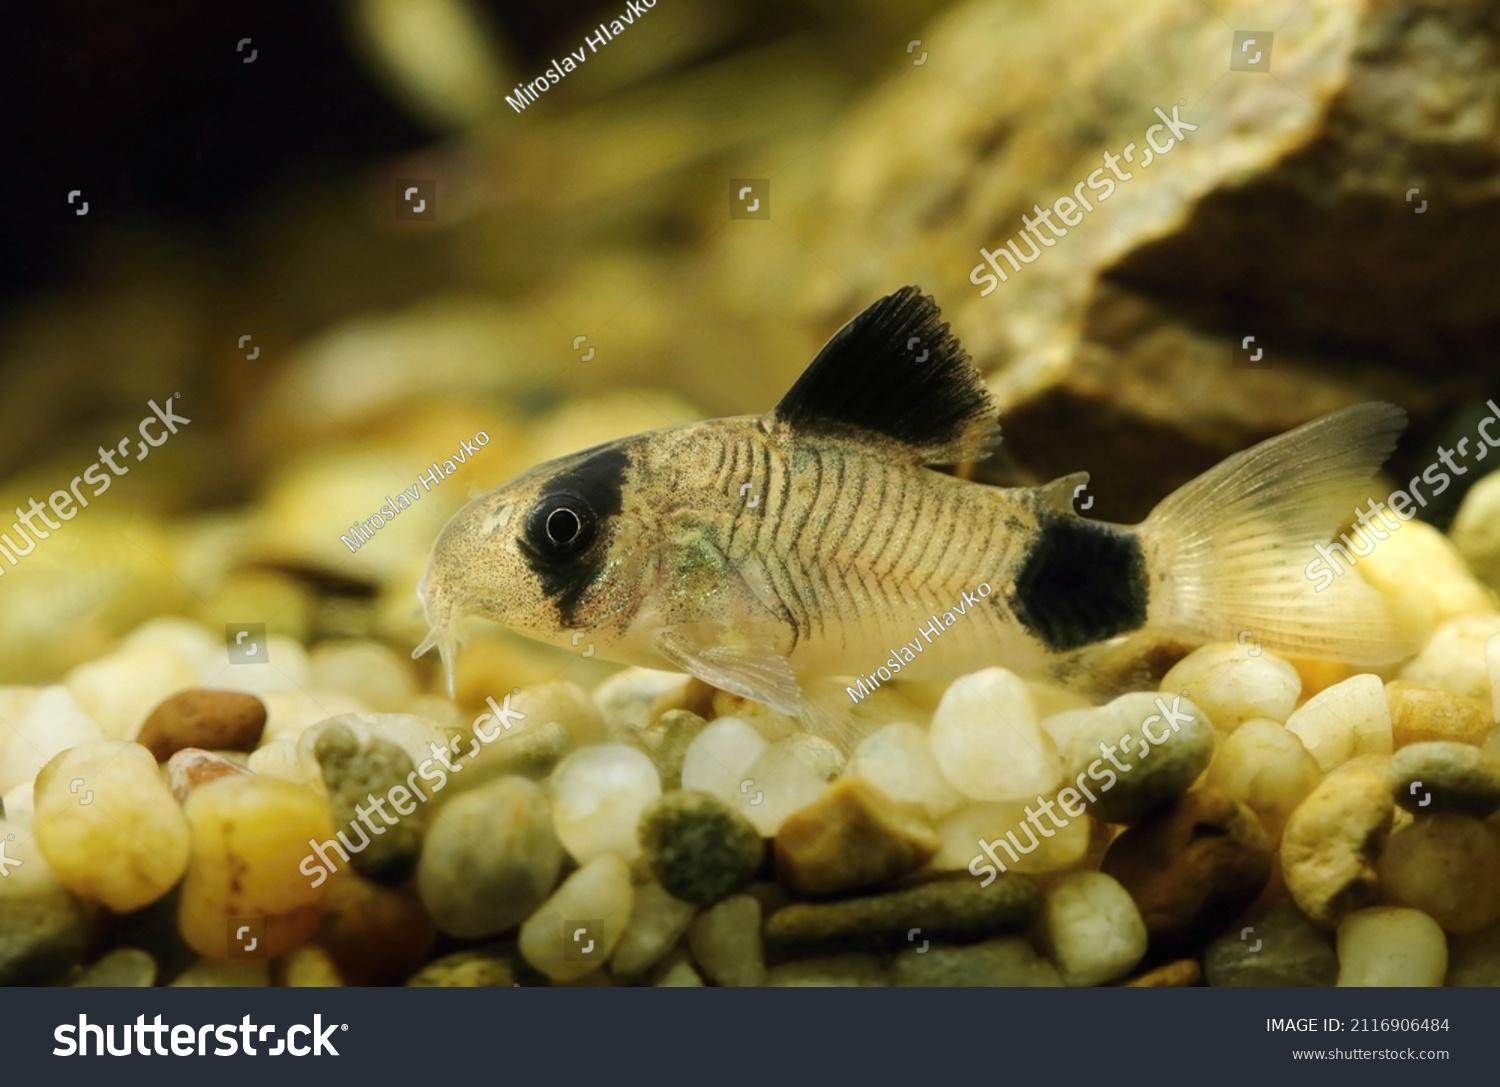

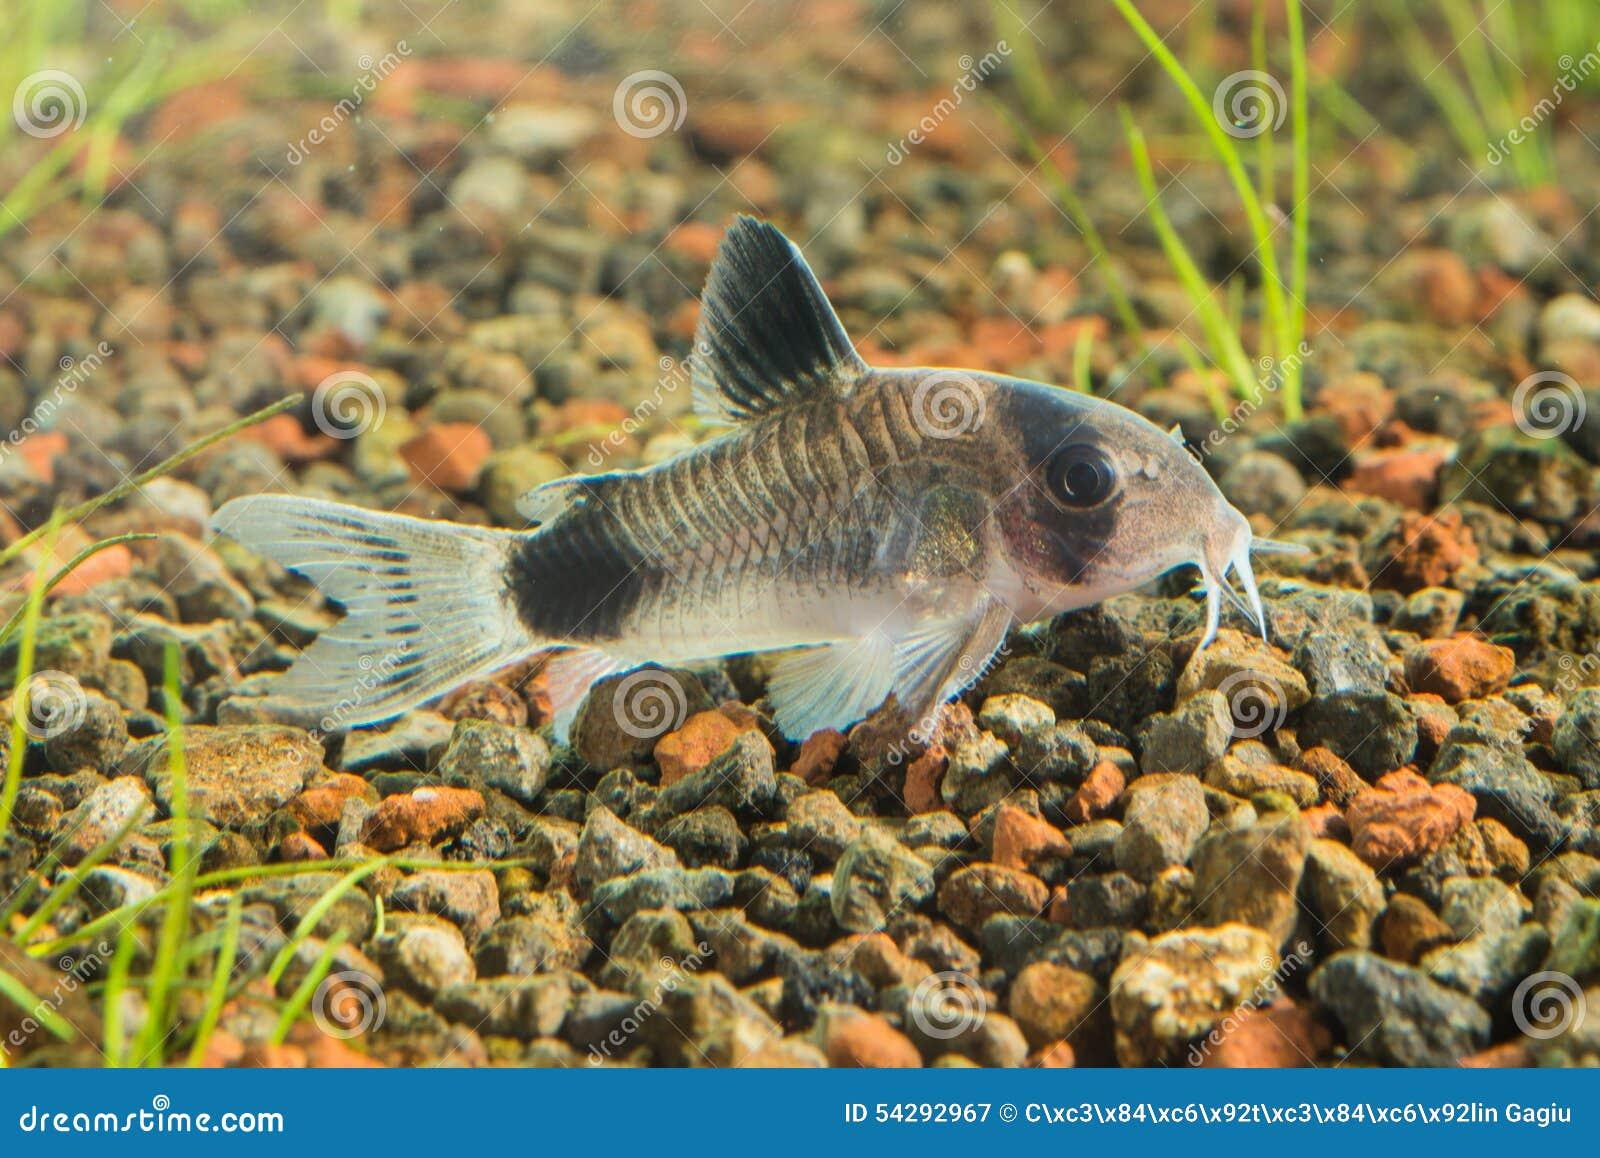

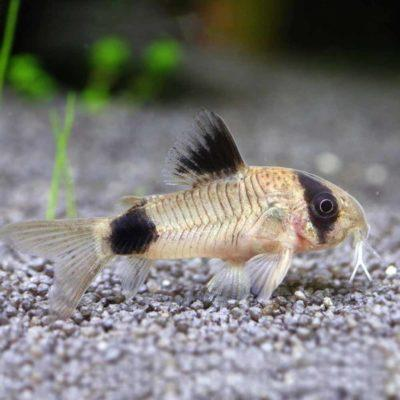

In [40]:
for im in similar_images:
    display(im)